In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
from pandas_datareader import wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time
from wb_api_wraper import *

In [3]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3").squeeze()

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("inputs/names_to_iso.csv", usecols=["iso2","iso3"]).drop_duplicates().set_index("iso2").squeeze() #the tables has more lines than countries to account for several ways of writing country names

In [5]:
mehdi_folder = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\Mehdi\\Opti RAI\\Result RAI\\Objective 1% GDP\\"

In [6]:
all_rai_data = pd.DataFrame()
for myfilename in os.listdir(mehdi_folder):
    myfile = pd.read_excel(mehdi_folder+"/"+myfilename)
    myinfo = myfilename.replace(".csv",'').split("_")
    myfile["country"] = myinfo[0]
    myfile = myfile.reset_index().rename(columns={"index":"connection_order"}).set_index(["country","connection_order"])
    if 'Cumu_People' not in myfile.columns:
        myfile['Cumu_People'] = myfile['New_People'].cumsum(axis=0)
    all_rai_data = all_rai_data.append(myfile)

In [7]:
all_rai_data.columns

Index(['Cost_upgrade', 'Cumu Distance', 'Cumu_People', 'Inter_PS',
       'Length_Roads', 'Linked_Net', 'Linked_Network', 'New_People', 'People',
       'People_per_km', 'Rai_Increase(%)'],
      dtype='object')

all_rai_data[['Cumu_People','Cumulative People']].isnull().sum(axis=0)

all_rai_data['Cumu_People_corrected'] = all_rai_data['Cumu_People'].fillna(all_rai_data['Cumulative People'])

In [8]:
all_rai_data.Cumu_People.isnull().sum()

0

In [9]:
len(all_rai_data)

50046

In [10]:
all_rai_data["Cumu_People_corrected"] = all_rai_data.Cumu_People

In [11]:
tostudy = all_rai_data[["Cost_upgrade","Length_Roads","Rai_Increase(%)","Cumu_People_corrected"]]

In [12]:
last_row = tostudy.reset_index().dropna().groupby("country").apply(lambda x:x.loc[x["Rai_Increase(%)"].argmax()])

In [13]:
last_row['half_cost'] = last_row.Cost_upgrade/2

In [14]:
tostudy2 = tostudy.reset_index().merge(last_row[["country","half_cost"]],on="country",how='left')

In [15]:
tostudy3 = tostudy2.dropna().groupby("country").apply(lambda x:x.loc[(x.Cost_upgrade<x.half_cost)])

In [16]:
half_row = tostudy3.groupby(level="country").apply(lambda x:x.loc[x["Rai_Increase(%)"].argmax()])

In [17]:
last_row["country"] = last_row.country.replace(iso3_to_wb)

In [18]:
half_row["country"] = half_row.country.replace(iso3_to_wb)

In [19]:
data_folder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_rai_output_data/"

In [20]:
rai = pd.DataFrame()
for scenario in ["RAI_PS","RAI_PST","RAI_PSTT"]:
    x = pd.read_excel(data_folder+"RAI_WorldPop.xlsx",sheetname=scenario)
    x["scenario"] = scenario
    rai = rai.append(x)

In [21]:
rai["country"] = rai.Country.replace(any_to_wb)
rai = rai.drop("Country",axis=1)

In [22]:
results = rai.loc[rai.scenario=="RAI_PS",:].merge(last_row,on="country",how="right").rename(columns={"Rai_Increase(%)":"new_RAI"})

In [23]:
results_half = rai.loc[rai.scenario=="RAI_PS",:].merge(half_row,on="country",how="right").rename(columns={"Rai_Increase(%)":"new_RAI"})

In [24]:
results_half["new_RAI"] = results_half.new_RAI.clip(upper = 100)

In [25]:
results["new_RAI"] = results.new_RAI.clip(upper = 100)

In [26]:
results_half["rai_increase"] = results_half.new_RAI-results_half.RAI

In [27]:
results["rai_increase"] = results.new_RAI-results.RAI

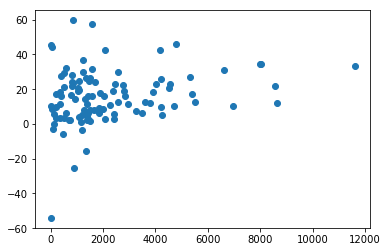

In [28]:
plt.scatter(results.Cost_upgrade,results.rai_increase)

In [29]:
results.loc[results.rai_increase>30,:]

,Pop Rural Total,Pop Rural < 2km,RAI,scenario,country,connection_order,Cost_upgrade,Length_Roads,new_RAI,Cumu_People_corrected,half_cost,rai_increase
11,0.000000e+00,0.000000e+00,0.000000,RAI_PS,Belarus,8,51.962925,22.685742,44.314266,2.320000e+02,25.981463,44.314266
17,1.484874e+07,3.366278e+06,22.670466,RAI_PS,Cote d'Ivoire,1201,11606.771829,47.618775,55.951817,4.957526e+06,5803.385915,33.281351
23,1.222575e+06,5.562922e+05,45.501666,RAI_PS,Costa Rica,773,1590.700551,17.710550,76.907232,3.874849e+05,795.350276,31.405566
34,1.678480e+07,7.352573e+06,43.804951,RAI_PS,Ghana,1272,7995.674587,2.138930,78.552506,5.898345e+06,3997.837293,34.747555
46,3.415893e+06,1.610635e+06,47.151211,RAI_PS,Jordan,462,603.019629,38.819637,79.089507,1.138880e+06,301.509815,31.938297
48,3.530720e+07,1.472446e+07,41.703839,RAI_PS,Kenya,1406,6602.816639,157.445638,73.019258,1.229619e+07,3301.408319,31.315419
50,1.305684e+07,4.973432e+06,38.090628,RAI_PS,Cambodia,1274,4159.972106,24.142719,80.745658,5.630029e+06,2079.986053,42.655030
53,8.617745e+05,2.296374e+05,26.647047,RAI_PS,Libya,262,1591.401596,227.360177,84.055045,1.513743e+05,795.700798,57.407998
66,1.422005e+07,5.188348e+06,36.486142,RAI_PS,Malawi,1675,4799.514412,6.797381,82.485907,6.812676e+06,2399.757206,45.999766
78,1.018176e+07,4.499838e+06,44.195089,RAI_PS,Rwanda,608,2064.817905,66.521459,86.498958,4.327039e+06,1032.408953,42.303868


In [30]:
results["new_people_served"] = results["Pop Rural < 2km"]+results["Cumu_People_corrected"]
results["new_people_served"] = results["new_people_served"].clip(upper = results["Pop Rural Total"])

In [31]:
results_half["new_people_served"] = results_half["Pop Rural < 2km"]+results_half["Cumu_People_corrected"]
results_half["new_people_served"] = results_half["new_people_served"].clip(upper = results_half["Pop Rural Total"])

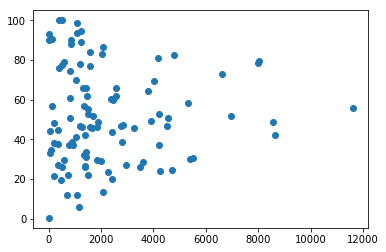

In [32]:
plt.scatter(results.Cost_upgrade,results.new_RAI)

In [33]:
results.loc[results.new_RAI>70,:]

,Pop Rural Total,Pop Rural < 2km,RAI,scenario,country,connection_order,Cost_upgrade,Length_Roads,new_RAI,Cumu_People_corrected,half_cost,rai_increase,new_people_served
2,3.691300e+05,2.462080e+05,66.699537,RAI_PS,Albania,316,867.238976,3.159622,90.070436,9.720400e+04,433.619488,23.370899,3.434120e+05
5,9.968155e+06,6.480396e+06,65.010982,RAI_PS,Burundi,573,1247.049063,7.093534,94.738197,3.015557e+06,623.524531,29.727214,9.495953e+06
10,7.420280e+05,5.876550e+05,79.195799,RAI_PS,Bosnia and Herzegovina,474,1098.224994,0.536043,98.707731,1.713310e+05,549.112497,19.511932,7.420280e+05
23,1.222575e+06,5.562922e+05,45.501666,RAI_PS,Costa Rica,773,1590.700551,17.710550,76.907232,3.874849e+05,795.350276,31.405566,9.437771e+05
27,1.063773e+07,7.721713e+06,72.587945,RAI_PS,Algeria,317,1211.439512,331.688067,77.955746,5.993148e+05,605.719756,5.367801,8.321028e+06
29,2.381491e+07,1.875439e+07,78.750634,RAI_PS,"Egypt, Arab Rep.",298,524.686676,11.444852,100.000000,5.673137e+06,262.343338,21.249366,2.381491e+07
34,1.678480e+07,7.352573e+06,43.804951,RAI_PS,Ghana,1272,7995.674587,2.138930,78.552506,5.898345e+06,3997.837293,34.747555,1.325092e+07
36,9.884683e+05,4.822433e+05,48.786930,RAI_PS,"Gambia, The",192,388.442025,42.302256,76.158490,2.704902e+05,194.221013,27.371560,7.527335e+05
42,7.975540e+05,6.690180e+05,83.883724,RAI_PS,Hungary,392,390.584549,0.880218,100.000000,1.639230e+05,195.292274,16.116276,7.975540e+05
45,8.530879e+05,4.099462e+05,48.054391,RAI_PS,Jamaica,298,505.455537,0.603399,77.337477,3.039296e+05,252.727768,29.283087,7.138758e+05


In [34]:
results["rai_per_dollar"] = results.rai_increase/results.Cost_upgrade

In [35]:
results["dollar_per_people"] = results.Cost_upgrade/results.Cumu_People_corrected

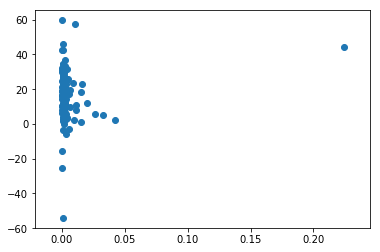

In [36]:
plt.scatter(results.loc[results.country!="Ukraine","dollar_per_people"],results.loc[results.country!="Ukraine","rai_increase"])

In [37]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

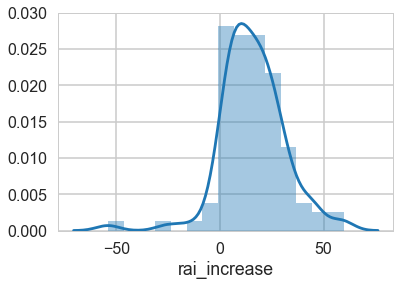

In [38]:
sns.distplot(results.rai_increase)

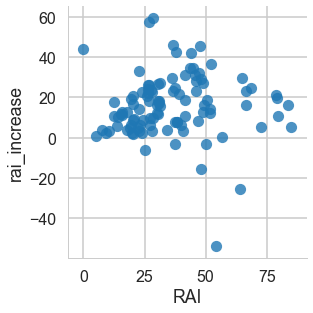

In [39]:
sns.lmplot("RAI", "rai_increase", data=results, fit_reg=False)

In [40]:
codes = pd.read_csv("C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/Mehdi/Analyse/wbccodes2014.csv")

In [41]:
codes.columns

Index(['country', 'country_name', 'wbregion', 'wbregionname', 'wbincome',
       'wbincomename', 'wblending', 'wbhipc'],
      dtype='object')

In [42]:
results["wbregionname"] = results.country.replace(codes.set_index("country_name").wbregionname) 

In [43]:
results_half["wbregionname"] = results_half.country.replace(codes.set_index("country_name").wbregionname) 

In [44]:
by_reg = results.set_index(["wbregionname","country"])[["rai_increase","Cost_upgrade"]].mean(level="wbregionname")

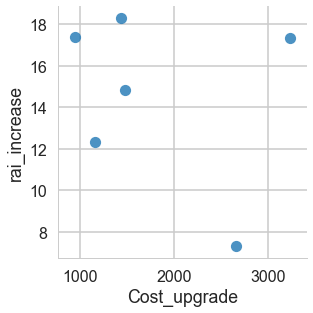

In [45]:
sns.lmplot("Cost_upgrade", "rai_increase", data=by_reg, fit_reg=False)

In [46]:
by_reg_half = results_half.set_index(["wbregionname","country"])[["rai_increase","Cost_upgrade"]].mean(level="wbregionname")

In [47]:
by_reg_half

,rai_increase,Cost_upgrade
wbregionname,,
East Asia & Pacific,4.457500,1321.422092
Europe & Central Asia,12.775902,499.290274
Latin America & Caribbean,10.353320,735.491362
Middle East & North Africa,15.700626,708.284071
South Asia,8.748802,573.989435
Sub-Saharan Africa,12.459549,1612.051780


In [48]:
by_reg_people = results.set_index(["wbregionname","country"])[["Pop Rural Total","new_people_served","Pop Rural < 2km"]].sum(level="wbregionname")

In [49]:
total_people = results.set_index(["wbregionname","country"])[["Pop Rural Total","new_people_served","Pop Rural < 2km"]].sum()

In [50]:
total_people[["new_people_served","Pop Rural < 2km"]].div(total_people["Pop Rural Total"],axis=0)

new_people_served    0.517095
Pop Rural < 2km      0.380098
dtype: float64

In [51]:
by_reg_people[["new_people_served","Pop Rural < 2km"]].div(by_reg_people["Pop Rural Total"],axis=0).to_csv("impact_1_percent_pop_served.csv")

In [52]:
by_reg_people_half = results_half.set_index(["wbregionname","country"])[["Pop Rural Total","new_people_served","Pop Rural < 2km"]].sum(level="wbregionname")

In [53]:
by_reg_people_half[["new_people_served","Pop Rural < 2km"]].div(by_reg_people["Pop Rural Total"],axis=0).to_csv("impact_05_percent_pop_served.csv")

In [54]:
by_reg_people[["new_people_served","Pop Rural < 2km"]].div(by_reg_people["Pop Rural Total"],axis=0)

,new_people_served,Pop Rural < 2km
wbregionname,,
East Asia & Pacific,0.609544,0.517728
Europe & Central Asia,0.398134,0.287215
Latin America & Caribbean,0.451071,0.335061
Middle East & North Africa,0.509289,0.394615
South Asia,0.569406,0.431556
Sub-Saharan Africa,0.464867,0.288665


In [55]:
by_reg_people_half[["new_people_served","Pop Rural < 2km"]].div(by_reg_people["Pop Rural Total"],axis=0)

,new_people_served,Pop Rural < 2km
wbregionname,,
East Asia & Pacific,0.587580,0.517728
Europe & Central Asia,0.277760,0.189390
Latin America & Caribbean,0.421947,0.335061
Middle East & North Africa,0.488497,0.394615
South Asia,0.535809,0.431556
Sub-Saharan Africa,0.421219,0.288665


In [ ]:
out = rai.set_index(["country","scenario"]).RAI.unstack("scenario")

In [5]:
road_paved_pc = get_wb_mrv('IS.ROD.PAVE.ZS',"road_paved_pc")

In [8]:
road_paved_pc.to_csv("inputs/road_paved_pc.csv")

In [6]:
#World Development Indicators
gdp_pc_pp    = get_wb_mrv('NY.GDP.PCAP.pp.kd',"gdp_pc_pp")#Gdp per capita ppp
pop          = get_wb_mrv('SP.POP.TOTL'      ,"pop")#population
#ppp_over_mer = get_wb_mrv('PA.NUS.PPPC.RF',"ppp_over_mer")#conversion factor PPP over MER
gdp_pc_cd=get_wb_mrv('ny.gdp.pcap.cd'   ,"gdp_pc_cd")#gdp per capita mer
# gap2     =get_wb_mrv('1.0.PGap.2.5usd'  ,"gap2")#poverty gap at 2$
# head2    =get_wb_mrv('SI.POV.2DAY'      ,"head2")# povety count at 2$
gini       = get_wb_mrv('SI.POV.GINI',"gini")

In [9]:
out = rai.set_index(["country","scenario"]).RAI.unstack("scenario")

In [11]:
play = out.RAI_PS

In [22]:
play.loc[(play<60)&(play>0)]

country
Afghanistan                       20.310014
Angola                            19.557927
Argentina                         43.174561
Armenia                           17.721927
Azerbaijan                        27.204838
Bangladesh                        47.032996
Belize                            26.670809
Benin                             36.090735
Bhutan                            34.188651
Bolivia                           20.502722
Botswana                          28.014343
Brazil                            35.528657
Bulgaria                          37.679667
Burkina Faso                      15.706451
Cambodia                          38.090628
Cameroon                          31.109553
Cape Verde                        56.770516
Central African Republic          22.825729
Chad                              13.924439
China                             57.370700
Colombia                          23.937524
Comoros                           24.323723
Congo, Dem. Rep.        

In [23]:
out['increase'] = out.RAI_PSTT-out.RAI_PS

In [25]:
out.loc[out.RAI_PSTT<50,:]

scenario,RAI_PS,RAI_PST,RAI_PSTT,increase
country,,,,
American Samoa,0.000000,0.000000,0.000000,0.000000
Angola,19.557927,40.896314,42.248379,22.690452
Armenia,17.721927,28.878332,29.454890,11.732963
Belarus,0.000000,0.000000,0.000000,0.000000
Central African Republic,22.825729,33.642108,40.811124,17.985395
Chad,13.924439,28.489657,35.284830,21.360391
"Congo, Rep.",12.506179,39.687739,45.960853,33.454674
Eritrea,23.286204,33.045347,34.526300,11.240095
"Iran, Islamic Rep.",20.344620,46.034194,49.292442,28.947822


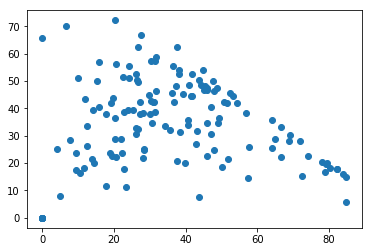

In [40]:
plt.scatter(out.RAI_PS,out.increase)

In [41]:
roads = pd.read_excel("Elco results\output_data\length_roads.xlsx")
roads["country"] = roads.Country.replace(any_to_wb)
roads = roads.fillna(0).drop("Country",axis=1)
roads = roads.set_index("country")
roads.columns.name = "road_type"
roads = roads.stack().reset_index().rename(columns={0:"km"})

In [42]:
roads

,country,road_type,km
0,Afghanistan,other,507.711221
1,Afghanistan,primary,6608.391766
2,Afghanistan,secondary,5537.112639
3,Afghanistan,tertiary,38426.022002
4,Afghanistan,track,57084.453671
5,Angola,other,343.306107
6,Angola,primary,8824.373143
7,Angola,secondary,8352.878989
8,Angola,tertiary,70977.249347
9,Angola,track,10847.372003


In [12]:
pd.read_excel(data_folder+"RAI_gpw.xlsx")

,Country,Pop Rural Total,Pop Rural < 2km,RAI
0,Afghanistan,2.493893e+07,5.628974e+06,22.571033
1,Angola,2.130044e+07,2.928206e+06,13.747162
2,Albania,1.333119e+06,7.511979e+05,56.348890
3,Argentina,2.211754e+07,5.678439e+06,25.673921
4,Armenia,1.107564e+06,2.055957e+05,18.562878
5,American Samoa,5.666631e+03,4.791430e+03,84.555167
6,Azerbaijan,5.946369e+06,1.621208e+06,27.263828
7,Burundi,8.868071e+06,5.567524e+06,62.781686
8,Benin,9.145383e+06,2.773378e+06,30.325440
9,Burkina Faso,1.692824e+07,3.029180e+06,17.894240


In [13]:
pd.read_excel(data_folder+"RAI_SSP3.xlsx")

,Country,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,Afghanistan,17.220670,17.805654,17.074742,16.162747,15.923948,15.489007,14.880107,14.602849,14.200263,13.622287,13.313094
1,Angola,8.588595,6.010599,5.802828,5.795954,5.615336,5.600894,5.634318,5.672812,5.720083,5.738772,5.723211
2,Albania,47.844150,41.523880,41.071438,41.177265,40.778982,41.026282,40.700578,40.816159,40.619968,40.021070,39.789884
3,Argentina,33.165816,22.874945,21.467091,20.531422,19.582538,19.478369,18.519383,18.522382,19.222210,18.470014,18.474210
4,Armenia,14.309439,10.790021,10.296645,10.645945,10.826446,11.082928,11.283880,11.457051,11.546049,11.705900,11.937337
5,Azerbaijan,33.744276,31.885145,31.771467,31.299539,30.898628,30.593267,30.349441,29.927482,30.081679,29.947702,29.376865
6,Burundi,63.591196,63.727840,63.763888,63.272809,62.714234,62.242540,62.184134,62.037843,61.897960,61.736649,61.564818
7,Benin,32.359514,25.646890,25.312831,24.656292,24.093138,23.902637,23.729837,23.676495,23.428250,22.905684,22.452040
8,Burkina Faso,18.848503,15.395510,14.654477,14.450542,14.067732,13.695704,13.341559,13.250595,12.948846,12.853652,12.811999
9,Bangladesh,24.333110,44.891384,44.808046,44.792375,44.531465,44.360715,44.231430,44.094778,43.860091,43.634430,43.538115
